In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import Timedelta
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']


# Analiza braków

In [11]:
sessions.isnull().mean()

timestamp     0.0
user_id       0.0
track_id      0.0
event_type    0.0
session_id    0.0
dtype: float64

In [146]:
artists.isnull().mean()
artists.genres.explode().value_counts()

genres
rock                        362
adult standards             254
soft rock                   252
mellow gold                 246
classic rock                241
                           ... 
metal uruguayo                1
ukrainian electronic          1
indie folk argentino          1
nuevo folklore argentino      1
focus trance                  1
Name: count, Length: 2904, dtype: int64

In [9]:
tracks.isnull().mean()

id                  0.000000
name                0.000000
popularity          0.000000
duration_ms         0.000000
explicit            0.000000
id_artist           0.000000
release_date        0.000000
danceability        0.000000
energy              0.000000
key                 0.000000
mode                0.800028
loudness            0.000000
speechiness         0.000000
acousticness        0.000000
instrumentalness    0.000000
liveness            0.000000
valence             0.000000
tempo               0.000000
time_signature      0.000000
dtype: float64

In [12]:
track_storage.isnull().sum()

track_id         0
storage_class    0
daily_cost       0
dtype: int64

In [175]:
users.isnull().sum()

user_id             0
name                0
city                0
street              0
favourite_genres    0
premium_user        0
dtype: int64

# Analiza informatywnosci

In [2]:
def extract_release_date(tdf: pd.DataFrame):
    def standardize_date(date):
        parts = date.split('-')
        if len(parts) == 1:  # Only year
            return f"{parts[0]}-01-01"
        elif len(parts) == 2:  # Year and month
            return f"{parts[0]}-{parts[1]}-01"
        return date
    
    def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
    tdf['standardized_date'] = pd.to_datetime(tdf['release_date'].apply(standardize_date))
    tdf['release_year'] = tdf['standardized_date'].dt.year
    tdf['release_daymonth'] = tdf['standardized_date'].dt.dayofyear
    tdf['date_completeness'] = tdf['release_date'].apply(date_completeness)

    return tdf.drop(columns=['standardized_date'])
tracks = pd.read_json("data/tracks.jsonl", lines=True)
tracks = extract_release_date(tracks).drop(columns=['release_date', 'mode'])

In [11]:
# block is group of consecutive user interactions with song
def transform_block(df: pd.DataFrame):
    
    def define_block_duration(group: pd.DataFrame):
        if 'skip' not in group['event_type'].values:
            return pd.Timedelta(milliseconds=min(group['duration_ms']))
        return max(group['timestamp'])-min(group['timestamp'])
    
    return df.groupby('block_id').agg(
        isskipped=('event_type', lambda x: 'skip' in x.values),
        isliked=('event_type', lambda x: 'like' in x.values),
        timestamp=('timestamp', lambda x: min(x)),
        track_id=('track_id', 'first'),
        user_id=('user_id', 'first'),
        block_duration = ('timestamp', lambda x: define_block_duration(df))
    ).reset_index(drop=True)

def transform_session(session: pd.DataFrame):
    session['block_id'] = (session['track_id'] != session['track_id'].shift()).cumsum()
    session = session.groupby('block_id').apply(transform_block).reset_index(drop=True)
    
    session['session_duration'] = session['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    session['session_skip_count'] = session['isskipped'].cumsum().shift(fill_value=0)
    session['session_like_count'] = session['isliked'].cumsum().shift(fill_value=0)
    session['session_play_count'] = range(len(session))
    
    session['session_skip_rate'] = (session['session_skip_count'] / session['session_play_count']).fillna(0)
    session.replace(np.inf, 0, inplace=True)
    
    session['session_ewma_rate'] = session['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)

    return session



def transform_user(user: pd.DataFrame):
    user['user_listen_time'] = user['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    user['user_skip_count'] = user['isskipped'].cumsum().shift(fill_value=0)
    user['user_like_count'] = user['isliked'].cumsum().shift(fill_value=0)
    user['user_play_count'] = range(len(user))
    user['user_skip_rate'] = (user['user_skip_count'] / user['user_play_count']).fillna(0)
    user.replace(np.inf, 0, inplace=True)
    user['user_ewma_rate'] = user['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)
    return user


def enrich_genres_similarity(df: pd.DataFrame):
    import itertools
    def genre_similarity(genres1, genres2):
        simillarity = 0
        for g1, g2 in itertools.product(genres1, genres2):
            indicator = 2
            if g1 != g2:
                words_genre1 = set(g1.lower().split())
                words_genre2 = set(g2.lower().split())
                indicator = 1 if any(word in words_genre2 for word in words_genre1) else 0
            simillarity += indicator
        return simillarity
    df['fav_genres_similarity'] = df.apply(lambda x: genre_similarity(x['genres'], x['favourite_genres']), axis=1)
    return df.drop(columns=['genres', 'favourite_genres'])

df = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
df = df.merge(tracks[['id', 'duration_ms']].set_index('id'), left_on="track_id", right_on='id')
df = df.groupby('session_id').apply(transform_session).reset_index().drop(columns=['level_1'])

df = df.groupby('user_id').apply(transform_user).reset_index(drop=True)

df = df.join(users.set_index('user_id'), on='user_id', rsuffix="_user").join(genres, on="track_id").join(tracks.set_index('id'), on="track_id", rsuffix="_track")
df = enrich_genres_similarity(df)

df.to_csv("data/result.csv")
target_df=df.drop(columns=[col for col in df.columns if 'id' in col])
target_df

,isskipped,isliked,timestamp,block_duration,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,release_daymonth,date_completeness,fav_genres_similarity
0,False,True,2023-01-02 05:58:46.000,0 days 00:07:17.813000,0 days 00:00:00,0,0,0,0.000000,0.000000,...,0.544,0.000239,0.6900,0.526,204.945,3,1981,238,full_date,12
1,False,True,2023-01-02 06:06:03.813,0 days 00:01:57.107000,0 days 00:07:17.813000,0,1,1,0.000000,0.000000,...,0.692,0.000000,0.1380,0.394,80.733,4,1980,1,full_date,12
2,False,True,2023-01-02 06:08:00.920,0 days 00:03:44.933000,0 days 00:09:14.920000,0,2,2,0.000000,0.000000,...,0.261,0.000000,0.0734,0.295,162.147,3,1998,1,full_date,8
3,False,True,2023-01-02 06:11:45.853,0 days 00:06:13.970000,0 days 00:12:59.853000,0,3,3,0.000000,0.000000,...,0.261,0.000140,0.0716,0.519,236.799,3,1970,152,full_date,12
4,True,False,2023-01-02 06:17:59.823,0 days 00:01:31.789000,0 days 00:19:13.823000,0,4,4,0.000000,0.000000,...,0.300,0.000330,0.4220,0.765,156.689,4,1979,32,year_month,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,True,False,2023-10-28 21:39:42.996,0 days 00:00:21.952000,0 days 02:43:03.485000,20,0,28,0.714286,0.040000,...,0.170,0.000000,0.2620,0.707,120.040,4,2017,209,full_date,0
12360,True,False,2023-10-28 20:51:07.988,0 days 00:01:54.734000,0 days 02:43:25.437000,21,0,29,0.724138,0.808000,...,0.430,0.000031,0.1080,0.919,78.990,4,2021,43,full_date,0
12361,True,False,2023-10-28 22:18:04.212,0 days 00:03:10.605000,0 days 02:45:20.171000,22,0,30,0.733333,0.961600,...,0.758,0.000000,0.1610,0.609,100.127,4,2020,177,full_date,0
12362,True,False,2023-10-28 20:48:16.560,0 days 00:02:46.428000,0 days 02:48:30.776000,23,0,31,0.741935,0.992320,...,0.842,0.000007,0.0999,0.124,80.434,4,2021,78,full_date,0


In [178]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
def preprocess_dataset(df: pd.DataFrame):
    final_dataset = df.dropna()
    label_encoder = LabelEncoder()
    final_dataset['city'] = label_encoder.fit_transform(final_dataset['city'])
    
    final_dataset['day']=final_dataset['timestamp'].dt.dayofyear
    final_dataset['hourminute']= final_dataset['timestamp'].dt.hour * 60 + final_dataset['timestamp'].dt.minute
    final_dataset['date_completeness'] = label_encoder.fit_transform(final_dataset['date_completeness'])
    
    final_dataset = final_dataset.drop(columns=['block_duration'])
    final_dataset['session_duration']=final_dataset['session_duration'].apply(lambda x: x.total_seconds())
    final_dataset['user_listen_time']=final_dataset['user_listen_time'].apply(lambda x: x.total_seconds())
    
    final_dataset['premium_user']=final_dataset['premium_user'].astype(int)
    final_dataset['isliked']=final_dataset['isliked'].astype(int)
    final_dataset['isskipped']=final_dataset['isskipped'].astype(int)
    
    # numeric_cols = final_dataset.select_dtypes(include=['float64']).columns
    # scaler = StandardScaler()
    # final_dataset[numeric_cols] = scaler.fit_transform(final_dataset[numeric_cols])
    
    return final_dataset.drop(columns=['timestamp', 'street', 'key', 'time_signature', 'explicit', 'name_track', 'name'])
final_dataset = preprocess_dataset(target_df)
final_dataset

,isskipped,isliked,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,user_listen_time,user_skip_count,...,instrumentalness,liveness,valence,tempo,release_year,release_daymonth,date_completeness,fav_genres_similarity,day,hourminute
0,0,1,0.000,0,0,0,0.000000,0.000000,0.000,0,...,0.000239,0.6900,0.526,204.945,1981,238,0,12,2,358
1,0,1,437.813,0,1,1,0.000000,0.000000,437.813,0,...,0.000000,0.1380,0.394,80.733,1980,1,0,12,2,366
2,0,1,554.920,0,2,2,0.000000,0.000000,554.920,0,...,0.000000,0.0734,0.295,162.147,1998,1,0,8,2,368
3,0,1,779.853,0,3,3,0.000000,0.000000,779.853,0,...,0.000140,0.0716,0.519,236.799,1970,152,0,12,2,371
4,1,0,1153.823,0,4,4,0.000000,0.000000,1153.823,0,...,0.000330,0.4220,0.765,156.689,1979,32,2,22,2,377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,1,0,9783.485,20,0,28,0.714286,0.040000,45985.748,111,...,0.000000,0.2620,0.707,120.040,2017,209,0,0,301,1299
12360,1,0,9805.437,21,0,29,0.724138,0.808000,46007.700,112,...,0.000031,0.1080,0.919,78.990,2021,43,0,0,301,1251
12361,1,0,9920.171,22,0,30,0.733333,0.961600,46122.434,113,...,0.000000,0.1610,0.609,100.127,2020,177,0,0,301,1338
12362,1,0,10110.776,23,0,31,0.741935,0.992320,46313.039,114,...,0.000007,0.0999,0.124,80.434,2021,78,0,0,301,1248


Accuracy: 0.7412050141528508


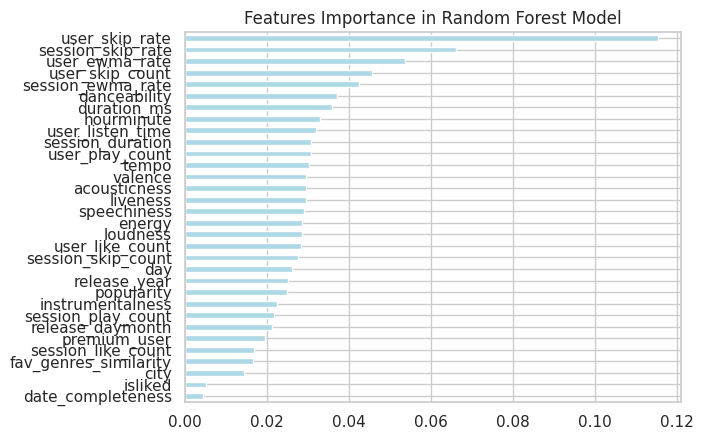

In [182]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

final_dataset = preprocess_dataset(target_df)
Y = final_dataset['isskipped']
X = final_dataset.drop(columns='isskipped')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

feature_importances = clf.feature_importances_
feature_names = X.columns
importances = pd.Series(feature_importances, index=feature_names)
importances_sorted = importances.sort_values()
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importance in Random Forest Model')
plt.show()

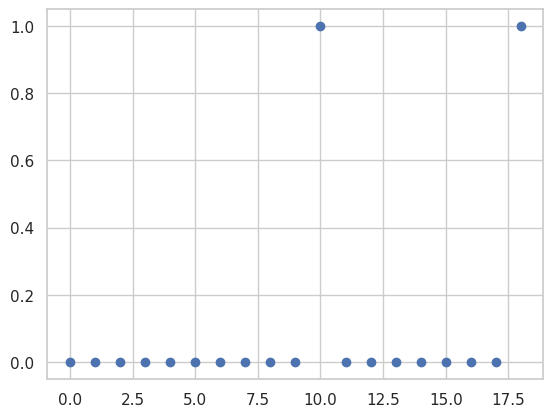

In [38]:

df = pd.read_csv('data/result.csv', index_col=0)
example_session = df[df['session_id']==150].reset_index(drop=True)

plt.scatter(example_session.index, example_session['isskipped'].astype(int))
